## Importing the necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/resume-dataset/Resume/Resume.csv
/kaggle/input/resume-dataset/data/data/DESIGNER/22506245.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/13998435.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/67582956.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/34349255.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/26790545.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/12674307.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/11807040.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/44145704.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/27497542.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/11155153.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/17555081.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/41506705.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/54201930.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/24583187.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/38565119.pdf
/kaggle/input/resume-dataset/data/data

In [2]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0951bf2e2adc3ad60e1cd0d2cd7f0afd46abae6dce238bfb0f8083245a3bd5cd
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import plot_model
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the dataset

In [64]:
df = pd.read_csv("/kaggle/input/resume-dataset/Resume/Resume.csv")
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [65]:
df.drop(columns = ['ID', 'Resume_html'], inplace = True)
df.head()

,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


## Exploratory Data Analysis (EDA)

In [9]:
df.shape

(2484, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Resume_str  2484 non-null   object
 1   Category    2484 non-null   object
dtypes: object(2)
memory usage: 38.9+ KB


In [11]:
df.isna().sum()

Resume_str    0
Category      0
dtype: int64

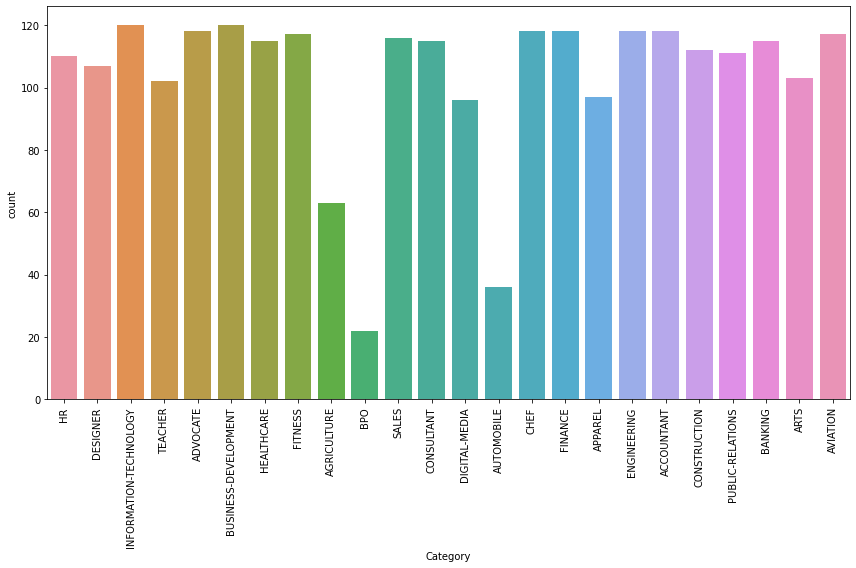

In [12]:
sns.countplot(df.Category)
plt.xticks(rotation=90)
plt.tight_layout();

In [66]:
print("Total number of available jobs:", df.Category.nunique())

Total number of available jobs: 24


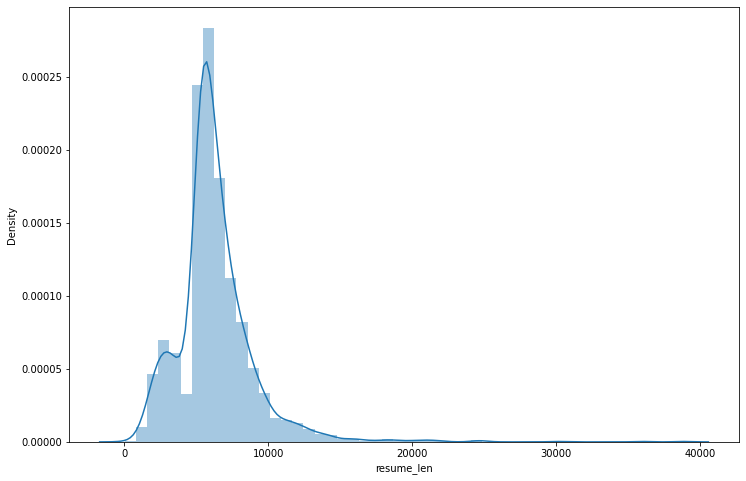

In [15]:
df['resume_len'] = df.Resume_str.apply(len)
sns.distplot(df.resume_len);

In [16]:
df.describe()

,resume_len
count,2484.000000
mean,6295.308776
std,2769.251458
min,21.000000
25%,5160.000000
50%,5886.500000
75%,7227.250000
max,38842.000000


In [17]:
max_resume_len = 200

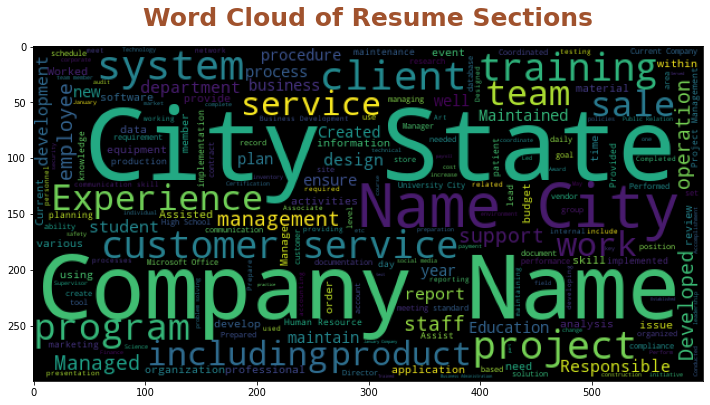

In [19]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.Resume_str))
plt.title(label='Word Cloud of Resume Sections',pad=20,fontsize=25,fontweight='bold',color='sienna')
plt.imshow(wc);

## Encoding the target labels i.e. all available jobs

In [67]:
labels_dict = {}

for idx, label in enumerate(df.Category.unique()):
    labels_dict[label] = idx

labels_dict

{'HR': 0,
 'DESIGNER': 1,
 'INFORMATION-TECHNOLOGY': 2,
 'TEACHER': 3,
 'ADVOCATE': 4,
 'BUSINESS-DEVELOPMENT': 5,
 'HEALTHCARE': 6,
 'FITNESS': 7,
 'AGRICULTURE': 8,
 'BPO': 9,
 'SALES': 10,
 'CONSULTANT': 11,
 'DIGITAL-MEDIA': 12,
 'AUTOMOBILE': 13,
 'CHEF': 14,
 'FINANCE': 15,
 'APPAREL': 16,
 'ENGINEERING': 17,
 'ACCOUNTANT': 18,
 'CONSTRUCTION': 19,
 'PUBLIC-RELATIONS': 20,
 'BANKING': 21,
 'ARTS': 22,
 'AVIATION': 23}

In [68]:
df.Category = df.Category.apply(func=lambda x: labels_dict[x])
df.Category = df.Category.astype(np.int64)

## Text Preprocessing

In [25]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [27]:
preprocessed_df = text_preprocess(df,'Resume_str')
preprocessed_df.head()

,Resume_str,Category,resume_len
0,hr administrator marketing associate hr admini...,0,5442
1,hr specialist us hr operations summary versati...,0,5572
2,hr director summary over years experience recr...,0,7720
3,hr specialist summary dedicated driven dynamic...,0,2855
4,hr manager skill highlights hr skills hr depar...,0,9172


## Downloading the pretrained tokenizer and DistilBert model 

In [28]:
tokenizer = AutoTokenizer.from_pretrained("manishiitg/distilbert-resume-parts-classify")
bert_model = TFDistilBertForSequenceClassification.from_pretrained("manishiitg/distilbert-resume-parts-classify",from_pt=True)

Downloading:   0%|          | 0.00/258 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## Splitting the preprocessed dataset into training and test sets

In [29]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,shuffle=True,random_state=101)

## Text Tokenization

In [31]:
X_train = tokenizer(text=train_df.Resume_str.tolist(),
                   add_special_tokens=True,
                   padding=True,
                   truncation=True,
                   max_length=max_resume_len,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

X_test = tokenizer(text=test_df.Resume_str.tolist(),
                  add_special_tokens=True,
                  padding=True,
                  truncation=True,
                  max_length=max_resume_len,
                  return_tensors='tf',
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=1)

## Defining the model architecture

In [33]:
input_ids = Input(shape=(max_resume_len,),dtype=tf.int32,name='input_ids')
attention_masks = Input(shape=(max_resume_len,),dtype=tf.int32,name='attention_mask')

In [34]:
word_embeddings = bert_model(input_ids,attention_mask=attention_masks)[0] # 0 --> final hidden state, 1 --> pooling output

output = Flatten()(word_embeddings)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=25,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_masks],outputs=output)
model.layers

In [35]:
model.layers[2].trainable = True

## Visualizing the model architecture

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_for_sequence_cla TFSequenceClassifier 66962700    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
flatten (Flatten)               (None, 12)           0           tf_distil_bert_for_sequence_c

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


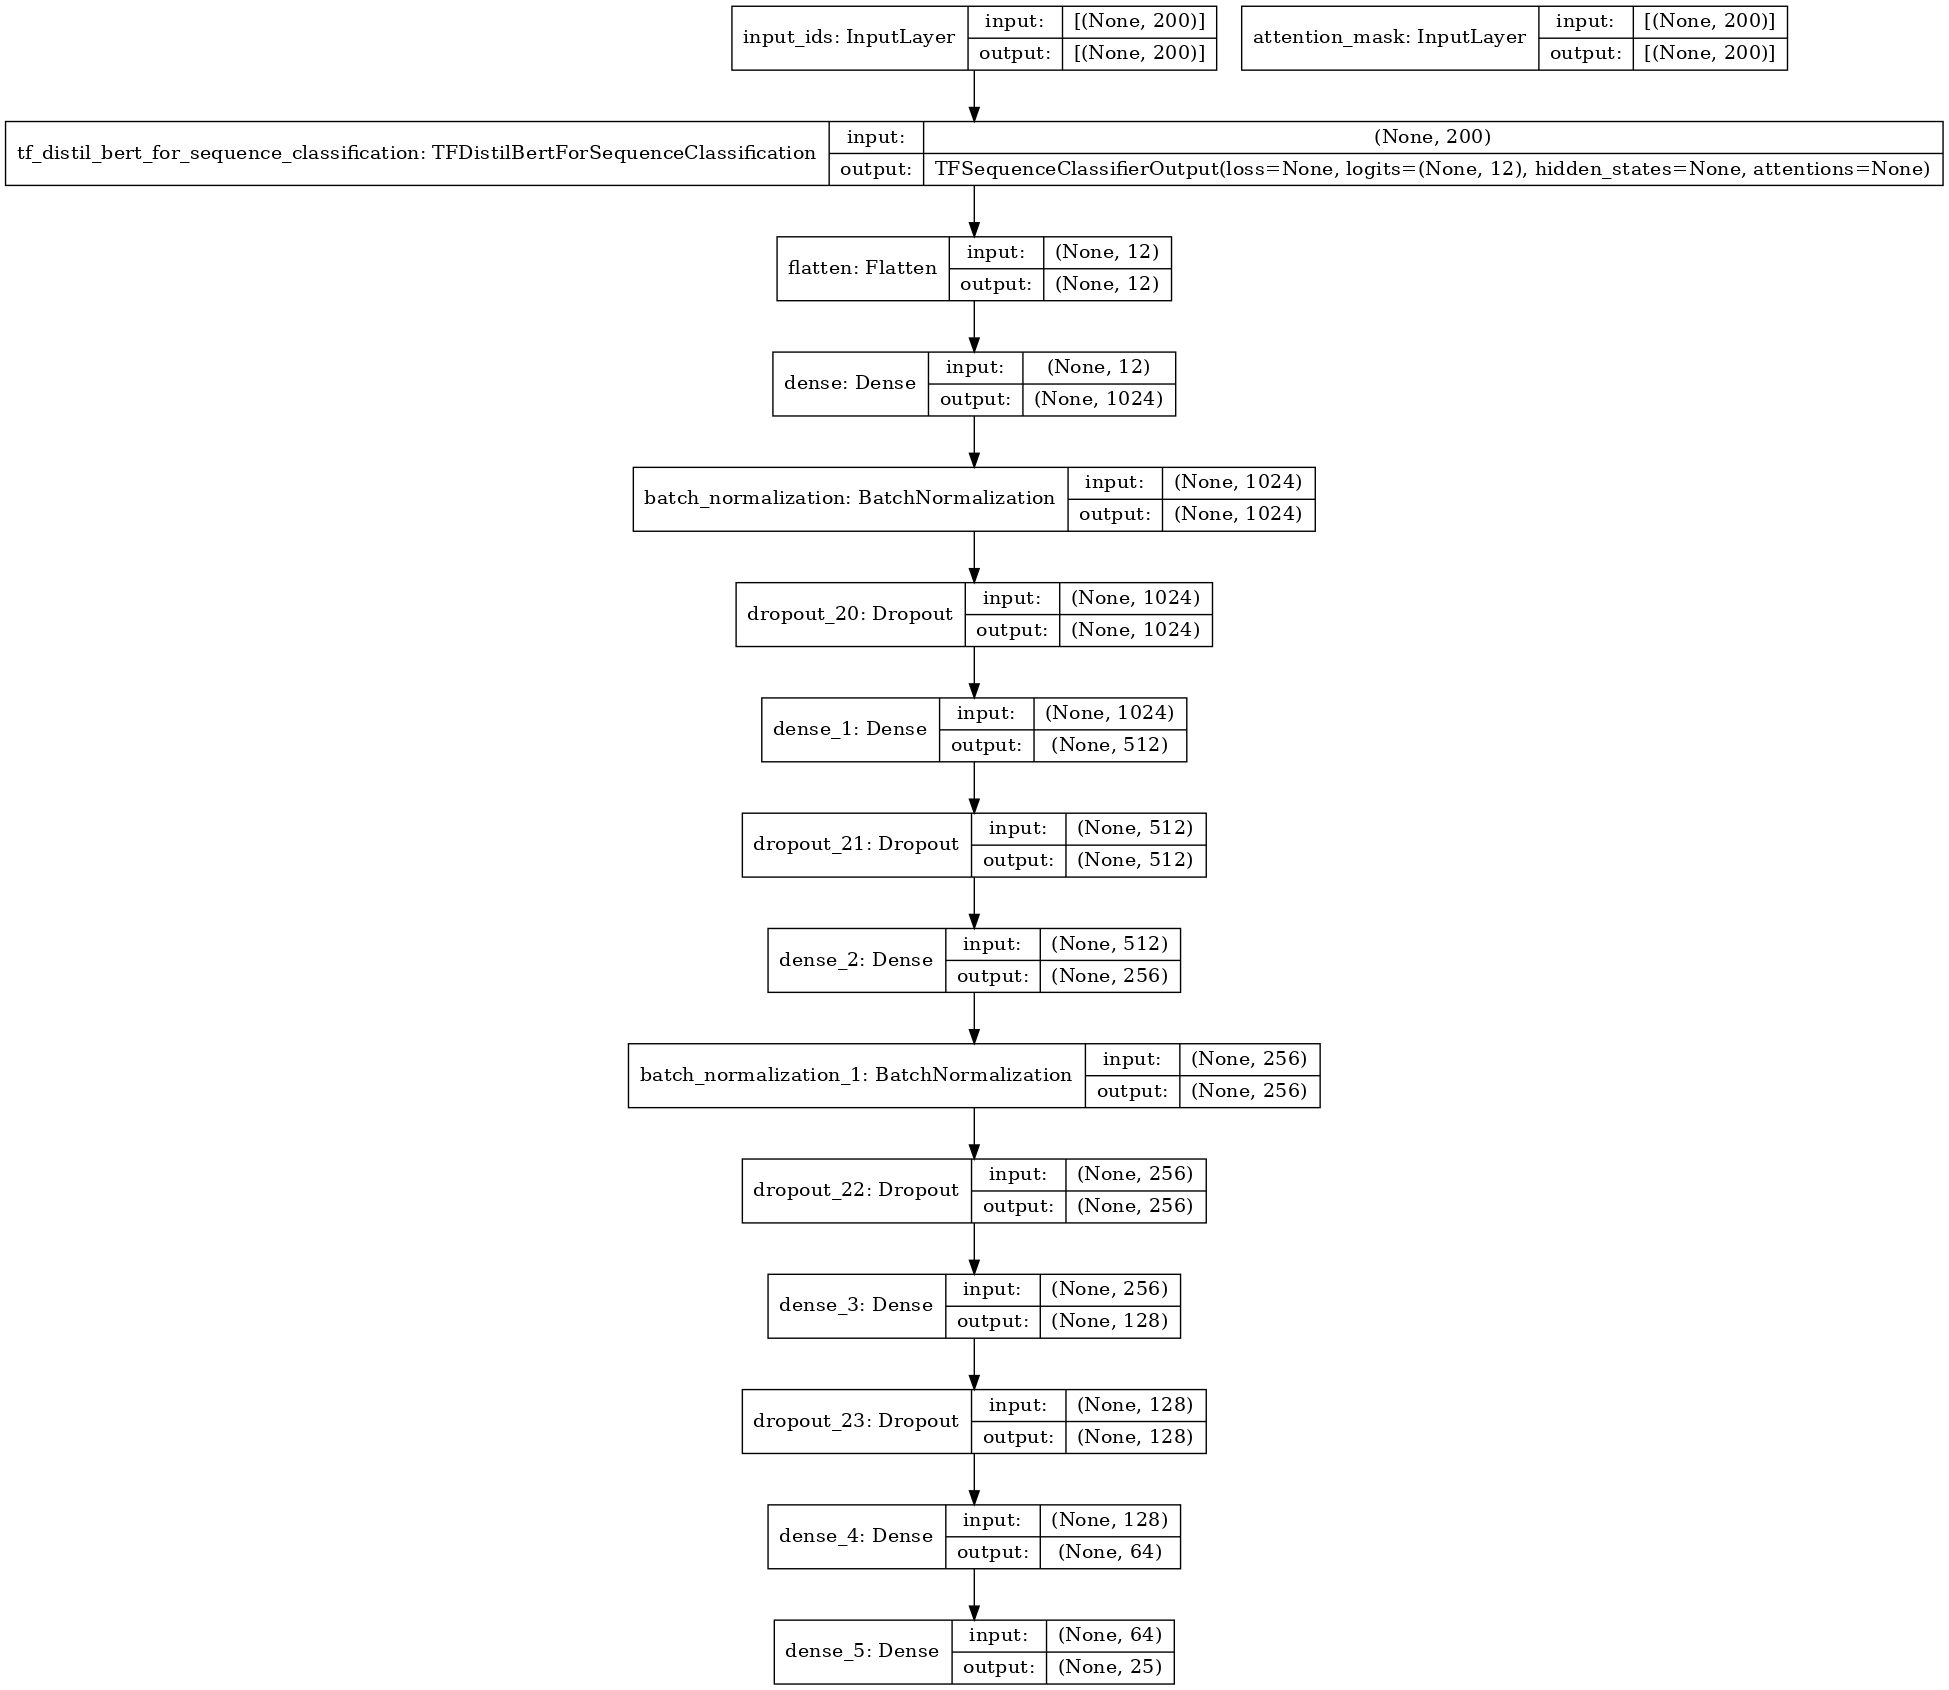

In [37]:
plot_model(model,to_file='model.png',dpi=100,show_shapes=True)

## Compiling the model

In [38]:
adam = Adam(learning_rate=5e-5,
           epsilon=2e-8,
           decay=0.01,
           clipnorm=1.0)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=SparseCategoricalAccuracy('balanced_accuracy'))

## Training the fine-tuned Distil-Bert model

In [39]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=250,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint('resume_parser.h5',monitor='val_balanced_accuracy',mode='max',verbose=1,save_best_only=True)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=train_df.Category,
             epochs=500,
             batch_size=32,
             callbacks=[es,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category))

Epoch 1/500
55/55 [==============================] - 52s 733ms/step - loss: 3.6277 - balanced_accuracy: 0.0455 - val_loss: 3.2178 - val_balanced_accuracy: 0.0563

Epoch 00001: val_balanced_accuracy improved from -inf to 0.05630, saving model to resume_parser.h5
Epoch 2/500
55/55 [==============================] - 40s 729ms/step - loss: 3.5302 - balanced_accuracy: 0.0460 - val_loss: 3.2024 - val_balanced_accuracy: 0.0643

Epoch 00002: val_balanced_accuracy improved from 0.05630 to 0.06434, saving model to resume_parser.h5
Epoch 3/500
55/55 [==============================] - 41s 741ms/step - loss: 3.4049 - balanced_accuracy: 0.0570 - val_loss: 3.1829 - val_balanced_accuracy: 0.0576

Epoch 00003: val_balanced_accuracy did not improve from 0.06434
Epoch 4/500
55/55 [==============================] - 40s 736ms/step - loss: 3.3212 - balanced_accuracy: 0.0777 - val_loss: 3.1578 - val_balanced_accuracy: 0.0979

Epoch 00004: val_balanced_accuracy improved from 0.06434 to 0.09786, saving model t

## Visualizing the model performance

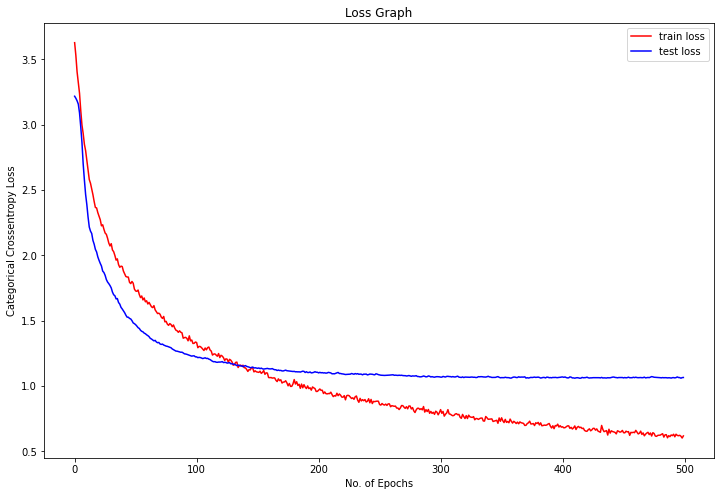

In [139]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();
plt.savefig('Loss_Graph.png')

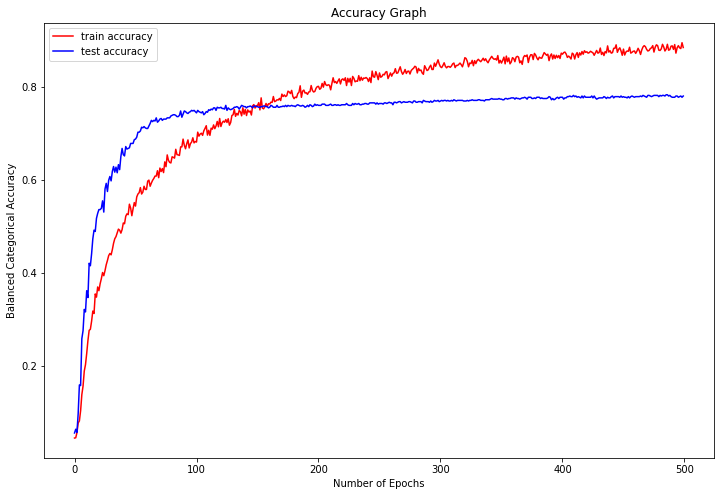

In [142]:
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Balanced Categorical Accuracy')
plt.title('Accuracy Graph')
plt.legend();
plt.savefig('accuracy.png')

## Model Evaluation

In [42]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category)
print("Test Sparse Categorical Crossentropy Loss:", loss)
print("Test Balanced Categorical Accuracy:", acc)

24/24 [==============================] - 5s 198ms/step - loss: 1.0653 - balanced_accuracy: 0.7802
Test Sparse Categorical Crossentropy Loss: 1.065347671508789
Test Balanced Categorical Accuracy: 0.7801608443260193


In [43]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
test_predictions

array([23,  5, 20,  5,  4,  1, 21, 21, 14, 18, 17, 20, 17,  0, 19, 17, 23,
       15, 22,  0, 19,  2, 14, 17, 23, 18,  3, 15, 17,  3, 11,  1, 17, 21,
       19,  1, 21, 22,  2,  1, 20, 19,  5, 19,  3, 10,  5, 18,  1, 14, 14,
       21, 16,  4, 12,  1,  2,  0, 14,  1,  7, 10, 10, 10,  3,  7,  7, 16,
        0,  0,  3, 12, 17, 21, 19,  0, 14,  6, 19, 17, 16, 20,  1, 14,  2,
        5,  1, 15, 23, 14, 14, 16, 21, 21,  2, 15, 20,  1, 21,  1, 10,  8,
       15, 19,  7, 10, 19, 21, 17, 10,  0, 19,  0,  6, 11, 17, 10, 22, 21,
       21,  6, 23, 21, 21, 11, 12,  1,  6, 19,  5,  2, 20, 21,  1, 15,  6,
       19, 12, 19, 10, 16,  4, 15, 22, 10, 21,  5, 11, 20, 11, 17,  3, 20,
       10, 20, 12, 18,  1, 12,  4, 23,  2, 22, 20,  2,  3,  6,  0,  4,  2,
       23,  4, 22, 10,  6, 18, 21,  5, 10,  7, 23,  7, 18, 20,  7, 12,  5,
        2,  2, 21, 11, 15, 20, 21,  7, 20, 22,  7,  1,  4,  4, 21, 21, 19,
       22, 20,  0, 23,  1, 21, 23, 20,  4, 22, 23,  1,  4,  1, 12, 18, 18,
        1,  1,  5, 23, 12

In [44]:
print("Confusion Matrix:")
print(confusion_matrix(test_df.Category,test_predictions))
print("Classification Report:")
print(classification_report(test_df.Category,test_predictions))

Confusion Matrix:
[[30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 47  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  2]
 [ 0  1  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0 27  0  3  2  0  0  1  0  0  0  0  0  0  0  0  0  1  1  0  2]
 [ 0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0 20  1  0  0  0  1  0  0  1  0  0  0  0  1  1  1  4  1]
 [ 0  0  0  1  2  0  2 22  0  0  2  0  2  0  1  0  0  0  0  0  0  2  2  0]
 [ 0  0  0  0  0  0  1  0  3  0  0  0  3  0  0  0  1  0  0  0  0  2  5  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  1  0  2]
 [ 0  0  0  0  0  0  0  2  0  0 34  0  0  0  0  0  1  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  1  0  1  2  0  0  0  2  0 15  0  0  0  0  0  0  0  2  0  1  2]
 [ 0  0

In [46]:
X_test['input_ids']

<tf.Tensor: shape=(746, 200), dtype=int32, numpy=
array([[  101,  4450,  2121, ...,  9675, 15117,   102],
       [  101,  3353,  2000, ..., 17785,  3454,   102],
       [  101,  2270,  4262, ...,  4433,  6510,   102],
       ...,
       [  101,  5766,  2343, ...,  2449,  2658,   102],
       [  101,  2622,  8911, ...,  8663,  6494,   102],
       [  101,  4113,  3836, ..., 20456,  2640,   102]], dtype=int32)>

In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# Load the pre-trained model with custom objects
model = load_model('/content/drive/MyDrive/resume_parser.h5', custom_objects={'TFDistilBertForSequenceClassification': TFDistilBertForSequenceClassification})
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


# Tokenize the Resume_str column
encoded_input = tokenizer(list(test_df['Resume_str']),
                          add_special_tokens=True,
                          padding=True,
                          truncation=True,
                          max_length=200,
                          return_tensors='tf')

# Make predictions
predictions = model.predict({'input_ids': encoded_input['input_ids'],
                              'attention_mask': encoded_input['attention_mask']})


predicted_category_index = np.argmax(predictions, axis=1)
predicted_category_labels = [list(labels_dict.keys())[index] for index in predicted_category_index]

# Add the predicted labels to the DataFrame
test_df['Predicted_Category'] = predicted_category_labels

# Save the DataFrame to a new CSV
output_csv_path = '/content/drive/MyDrive/categorized_resumes.csv'
test_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to {output_csv_path}")